# `AA` - Workshop 6

In this workshop we will dive into classification. Classification is the prediction of classes. This means our target variable can take only a set of discrete values (versus the continuous case for regresssion). 

We will cover the following: 
1. Linear Classification
1. Evaluating Classification Models

Whereas our previous introduction to machine learning focused on the case of predicting real-valued outputs (called the regression setting), these notes consider the case of predicting discrete-valued outputs. This is called the classification setting. And while it may seem as though this would require very different techniques to handle (after all, the regression setting we just considered made very "continuous" predictions rather than discrete ones), one nice thing about our generic framework for machine learning is that in reality, there is very little difference between how we handle regression and classification problems. Like before, there are hypothesis functions, loss functions, and our goal is still to solve the canonical problem of minimizing the sum of losses on a data set (the only real difference is in the choice of loss function, as we will see even the hypothesis class largely remains the same).



## `Linear Classification`

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

Let us first consider a very simple illustrative example...

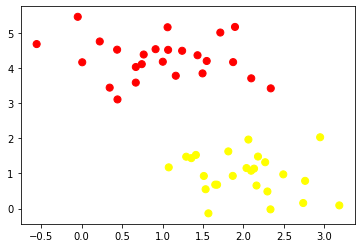

In [2]:
# make_blobs generates isotropic Gaussian blobs for clustering
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

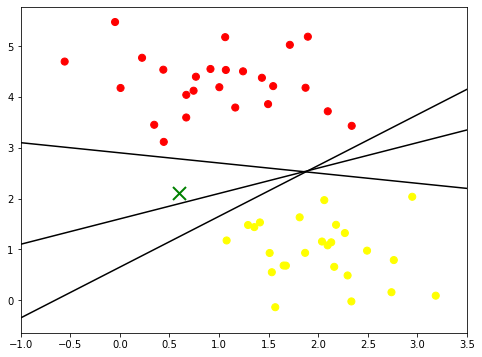

In [3]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize = (8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='green', markeredgewidth=2, markersize=13)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three very different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Example: breast cancer classification

As an example to introduce classification problem, we're going to turn to a classical example from the machine learning literature, first presented in [[Street et al, 1993]](http://ftp.cs.wisc.edu/math-prog/tech-reports/olm102.ps) of identifying whether cancer cells from a biospy are malignant or benign.  This was historically an important data set in the intersection of machine learning and health care, and similar subjects are still a topic of very active research.  Of course, 25 years ago, the techniques were much more primitive and computationally less intense than current approaches to similar problems, but the work has become a classical data set in machine learning, and also represent a compelling applications.

To create the data set, researchers took 569 images of cancerous cells, under a microscope, and manually selected the outlines of the different cells (this step is the kind of thing that would ideally be replaced by automatic computer vision architectures in current systems).  The resulting figures looked like this:
![Image of (manually) selected outlines of cells under a microscope.](cancercells.png)
The researchers then considered 10 different features of each cell, of instance the area, perimeter, texture, number of concave points (i.e., indentations), variance of grayscale color, and some others (a full list is in the above paper).  For each of these 10 features they computed the mean, max, and standard deviation of the feature across all the cells in the image, resulting in a 30 dimensional vector describing each sample.

The following is a plot of two of these features (mean # of concave points, and mean area) for all examples in the data set; blue points denotes a benign tumor, whereas red points denote a malignant tumor.  (Note that the dataset is so common, it's included in the actual scikit-learn package itself).

In [4]:
cancer_df = pd.read_csv("breast_cancer.csv", index_col = "id")
cancer_df.head(3)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN


Let us plot `area_mean` vs. `concave points_mean` and see how the results differ for **malignant** and **benign** tumors:

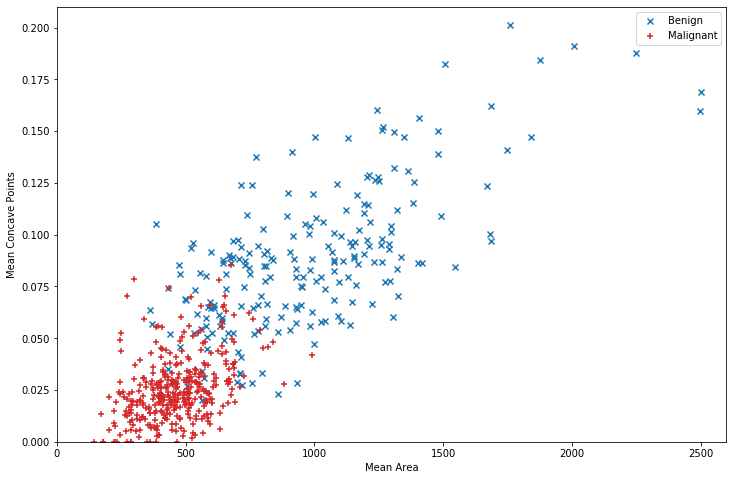

In [5]:
def plot_cells():
    plt.figure(figsize=(12,8))
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C0')
    plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C3')
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend(['Benign', 'Malignant'])
    
plot_cells()

There is obviously some structure to the data here: cells with greater average area and greater numbers of concave points are more likely to be malignant. And whereas your mental model of simple linear regression should be something like "fitting a line to the data", your mental model of a classification task should be "separating the classes with a line". Something like the following (just a hand-picked example of a line, we will shortly see how to actually fit these to the data, much like we did for regression).

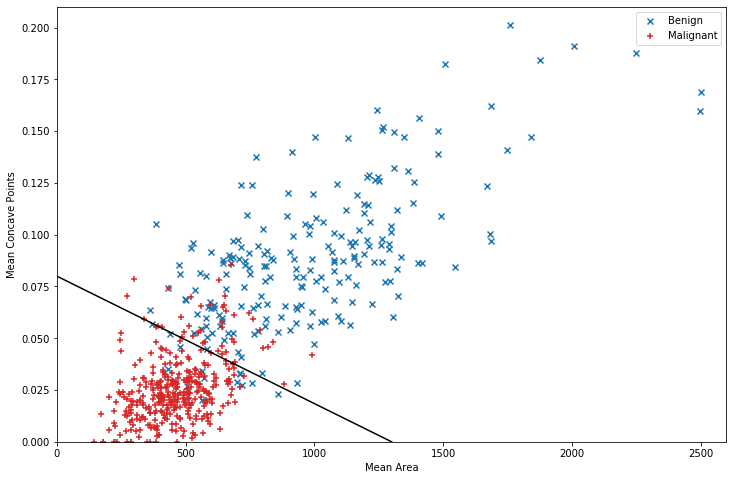

In [6]:
plot_cells()
plt.plot([0, 1300], [0.08,0], 'k-') # we manually fit a line here by defining the intercepts with the x- and y-axis
plt.show()

Just as our linear regression line did not pass exactly through all the data points, we can't achieve here a line that exactly separates all the data points. But there is clearly as sense in which points below the line are "more likely" to be benign, and above the line are "more likely" to be malignant. 

### Alternative losses for classification

Given the difficulties of minimizing sum of zero-one losses, one typically uses an alternative loss in classification.  There are many such losses, and different choices here lead to different machine learning algorithms (often with very little indication that all that differs between the algorithm is in fact the choice of loss function).  Let's consider a few of of the more common ones:

- **Logistic loss:** $\ell_{\mathrm{logistic}}(h_\theta(x), y) = \log(1+\exp(-h_\theta(x) \cdot y))$  <br/> For large positive values of $h_\theta(x) \cdot y$, $\exp(-h_\theta(x) \cdot y)$ will be very close to zero, so the loss will approach zero; for large negative values $\log(1+\exp(-h_\theta(x) \cdot y)) \approx -h_\theta(x) \cdot y$ so the loss increases approximately linearly.
- **Hinge loss:** $\ell_{\mathrm{hinge}}(h_\theta(x), y) = \max\{1 - h_\theta(x) \cdot y, 0\}$ <br/>  As long as $h_\theta(x) \cdot y \geq 1$, this loss will be zero, whereas it will increase linearly for negative $h_\theta(x) \cdot y \geq 1$.
- **Exponential loss:** $\ell_{\mathrm{exp}}(h_\theta(x), y) = \exp(-h_\theta(x) \cdot y)$ <br/> For a similar reason as with logistic loss, this loss will go to zero for large $h_\theta(x) \cdot y$; but for negative $h_\theta(x) \cdot y$ the loss increases very quickly.



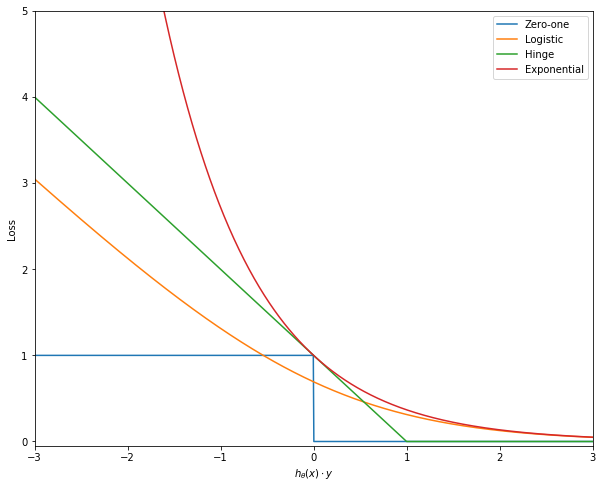

In [7]:
hy = np.linspace(-3,3,1000)
plt.figure(figsize = (10,8))
plt.plot(hy,(hy<=0))
plt.plot(hy, np.log(1+np.exp(-hy)))
plt.plot(hy, np.maximum(1 - hy, 0))
plt.plot(hy, np.exp(-hy))
plt.xlim([-3,3])
plt.ylim([-0.05, 5])
plt.ylabel("Loss")
plt.xlabel("$h_θ(x) \cdot y$")
plt.legend(['Zero-one', 'Logistic', 'Hinge', 'Exponential'])
plt.show()

## Solving classification tasks

With this framework and set of loss functions laid out, the task of learning a classifier is exactly the same as the regression methods we considered previously.  That is, given a data set we seek to minimize the average loss
\begin{equation}
\min_{\theta} \frac{1}{m}\sum_{i=1}^{m} \ell(h_{\theta}(x^{(i)}),y^{(i)})
\end{equation}

Unlike regression, there is virtually no setting (except, of course, just using least-squares loss) where there is an analytical solution to this optimization problem.  Nonetheless, we can still solve it by resorting back to gradient descent (there are alternative optimization approaches for most of these problems, but we'll only cover gradient descent).  To see how this works, we'll next consider some collection of specific machine learning algorithms that result in specific choices of loss function.




### `Support vector machine classification`

Support vector machines (SVMs) result from choosing hinge loss
\begin{equation}
\ell_{\mathrm{hinge}}(h_\theta(x),y) = \max \{1-h_\theta(x)\cdot y, 0\}
\end{equation}
as the loss function to minimize.  If you have seen support vector machines before, you may have seen them explained in a geometric context, illustrating that they maximize the "margin" of separation between examples of different classes.  This is true, and support vector machines absolutely can be viewed this way.  But it is also instructive to simply understand them as minimizing the particular loss function above.

Support vector machines also refer either to a linear hypothesis function, or a particular form of nonlinear hypothesis known as a _kernel_ hypothesis; if you ever hear the terms "linear SVM" or "kernel SVM", this is just the designation of which type of hypothesis function they are using.  That is, linear SVMs use the hypothesis function
\begin{equation}
h_\theta(x) = \sum_{j=1}^n \theta_j x_j = \theta^T x,
\end{equation}


**SVM Inutition: Maximizing the Margin**

Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

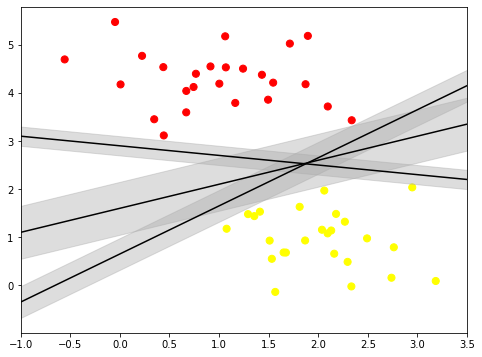

In [8]:
xfit = np.linspace(-1, 3.5)
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a maximum margin estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on breast cancer data.

The scikit-learn library, which we previously discussed in the context of regression, also has built-in algorithms for classification.  Using these again just requires the initialization, `.fit()`, and `.predict()` methods, with the additional note that if you want the actual output of the hypothesis function, you need to use the `.decision_function()` call.

There is also a `LinearSVC` class which uses a slightly different algorithm, but which is largely similar.  Note that this class by default uses the squared hinge loss rather than the hinge, so we need to specify `loss='hinge'` if we want the normal hinge. 

We also consider here the scikit-learn way of normalizing features.  This is done via the `sklearn.preprocessing.StandardScalar` class.  These have a similar interface as the machine learning classes, with a similar method `.fit()` (which computes the mean and variance of a column), and `.transform()` (which converts the data to have zero mean and unit variance).  Let's see how this class works.

In [9]:
X = np.array(cancer_df[['area_mean','concave points_mean']])
Y = cancer_df['diagnosis'].values

We again normlize our features using the StandarScaler class in scikit learn.

In [10]:
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()
X_norm = norm.fit_transform(X)  # simultaneously fit and transform 

**Recall**: StandardScaler normalizes to 0 mean and unit variance

In [11]:
print(np.mean(X, axis=0), np.std(X, axis=0))
print(np.mean(X_norm, axis=0),np.std(X_norm, axis=0))  # normalize to 0 mean and unit variance (var=std^2)

[6.54889104e+02 4.89191459e-02] [3.51604754e+02 3.87687325e-02]
[-2.18532476e-16 -3.74627101e-17] [1. 1.]


In [12]:
from sklearn.svm import LinearSVC # Linear Support Vector Classifier

model_SVM = LinearSVC(loss='hinge')
model_SVM.fit(X_norm, Y)  # Note: There is no need to encode Y. The algorithm does that automatically

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [13]:
def plot_classification_sklearn(model, norm):
    x_range = [0,2600]
    y_range = [0, 0.21]
    plt.figure(figsize = (10,8))
    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),  # create coordinate mesh
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(norm.transform(X_)).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C0')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C3')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2],['Benign', 'Malignant'])

How well does SVM Classification perform? Let us look at accuracy.

In [14]:
(model_SVM.predict(X_norm) == Y).mean()  # Note: mean() operation on booleans returns the proportion of True

0.9173989455184535

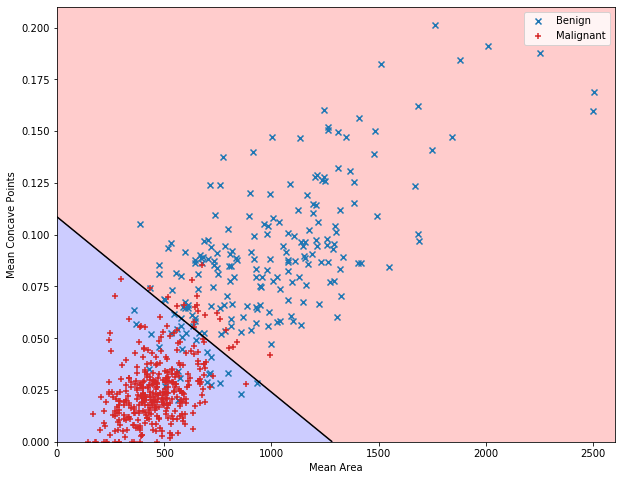

In [15]:
plot_classification_sklearn(model_SVM, norm)

### `Logistic regression`

Logistic regression results from choosing the logistic loss
\begin{equation}
\ell_{\mathrm{logistic}}(h_\theta(x), y) = \log(1+\exp(-h_\theta(x) \cdot y))
\end{equation}
as our classification loss to minimize.  Logistic regression also has a nice probabilistic interpretation: certain quantities give the _probability_, under a particular model, of an example being positive or negative. We will consider this probabilistic setting more in a later lecture, but for now we are going to simply treat it an another loss minimization algorithm.

Assuming a linear hypothesis function (the typical assumption under logistic regression), the partial deriative of the logistic loss is given by
\begin{equation}
\begin{split}
\frac{\partial}{\partial \theta_j} \log(1+\exp(-\theta^T x \cdot y)) & = \frac{1}{1+\exp(-\theta^T x \cdot y)} \frac{\partial}{\partial \theta_j} (1+\exp(-\theta^T x \cdot y))\\  
& = - \frac{\exp(-\theta^T x \cdot y)}{1+\exp(-\theta^T x \cdot y)} x_j\cdot y \\
& = -\frac{1}{1+\exp(\theta^T x \cdot y)} x_j\cdot y
\end{split}
\end{equation}
where in the last line we use the fact that
\begin{equation}
\frac{\exp(-x)}{1+\exp(-x)} = \frac{\exp(-x)}{1+\exp(-x)} \cdot \frac{\exp(x)}{\exp(x)} = \frac{1}{1+\exp(x)}
\end{equation}


Thus, the gradient of the entire objective function for logistic regression (we'll omit any regularization term, though we could also add this if desired) is given by

\begin{equation}
\begin{split}
\nabla_\theta E(\theta) & = 
\nabla_\theta \frac{1}{m} \sum_{i=1}^m \log \left (1+ \exp \left (\theta^T x^{(i)} \cdot y^{(i)} \right )\right) \\
& = \frac{1}{m} \sum_{i=1}^m -x^{(i)} y^{(i)} \frac{1}{1+\exp\left(\theta^T x^{(i)} \cdot y^{(i)}\right)}.
\end{split}
\end{equation}

We can use this derivation to write the gradient descent procedure for logistic regression, which differs in only two lines (the loss and gradient computation) from the support vector machine implementation.

For the purpose of this exercise, however, we will use the readily available `LogisticRegression` class in scikit learn.

In [16]:
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(C=1e3)   # C is a regularization term, we set it to 1000 here
model_log.fit(X_norm, Y)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

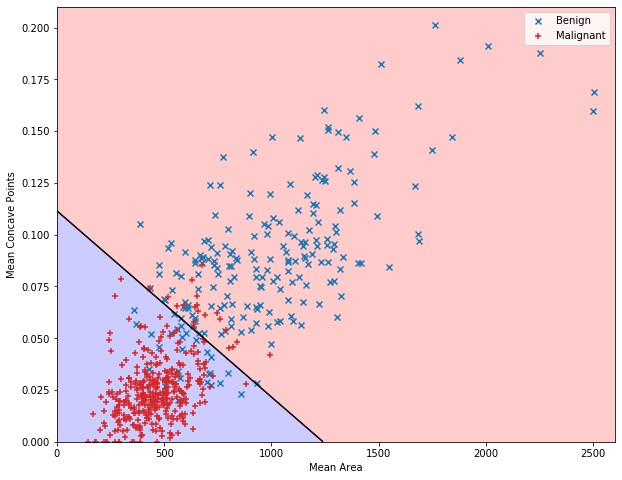

In [17]:
plot_classification_sklearn(model_log, norm)

How well does Logistic Regression perform? Let us look at accuracy.

In [18]:
(model_log.predict(norm.transform(X)) == Y).mean()  # Note: mean() operation on booleans returns the proportion of True

0.9191564147627417

**Task**: In the above we used just two features to classify the cancer cells. We achieved decent accuracy of >90%. Can we impove performance even further by including more information, i.e. more features?

In [19]:
cancer_df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [20]:
# YOUR CODE HERE

X_full = np.array(cancer_df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']])

Y = cancer_df['diagnosis'].values

#Transform
norm_full = StandardScaler()
X_norm_full = norm_full.fit_transform(X_full)


In [21]:
# train new model_SVM

model_SVM_full = LinearSVC(loss='hinge')
model_SVM_full.fit(X_norm_full,Y)

# return acuracy
(model_SVM_full.predict(X_norm_full) == Y).mean()

0.9876977152899824

In [22]:
# train new logistic model

model_log_full = LogisticRegression(C=1e3)
model_log_full.fit(X_norm_full,Y)

# return acuracy
(model_log_full.predict(X_norm_full) == Y).mean()

0.9964850615114236

## `Evaluating Classification models`

### Confusion Matrix

Confusion Matrix plots true negatives (TN) and true positives (TP) vs. false negatives (FN) and false positives (FP). What results is a 2x2 matrix that provides an overview of classifier performance. See the [Wikipedia article](https://en.wikipedia.org/wiki/Confusion_matrix) for more info.

Let us have a look at how this looks for our simplest case, the linear SVM prediction (`model_SVM`).

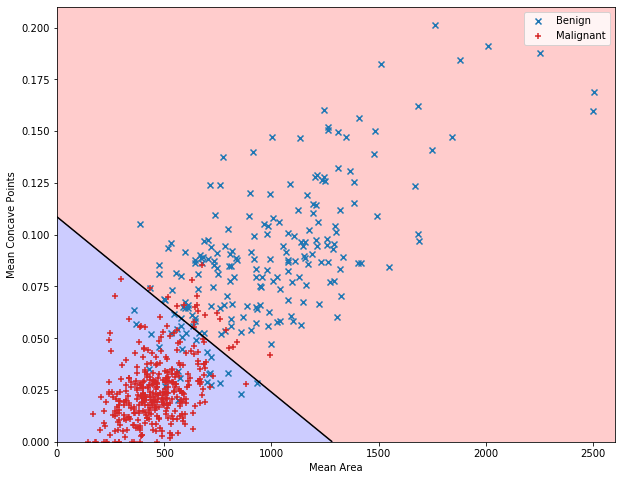

In [23]:
plot_classification_sklearn(model_SVM, norm)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y, model_SVM.predict(X_norm),labels=["B","M"])
print(confusion_matrix)

[[337  20]
 [ 27 185]]


From this confusion matrix various additional performance metrics can be derived. Let us consider some of the most common ones:


### Accuracy

Accuracy is the ratio of all correctly classified smaples vs. the total amount of samples. It is computed as follows:

\begin{equation}
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
\end{equation}

The scikit learn implementation is straight forward:

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(Y, model_SVM.predict(X_norm))
print(accuracy_score)

0.9173989455184535


Relating this back to the confusion matrix from above:

In [26]:
(337+185)/sum(sum(confusion_matrix))

0.9173989455184535

### Precision

Precision is the ratio of all correctly classified smaples vs. the total amount of samples. It is computed as follows:

\begin{equation}
Precision = \frac{TP}{TP+FP}
\end{equation}

The scikit learn implementation is as follows:

In [27]:
from sklearn.metrics import precision_score
precision_score = precision_score(Y, model_SVM.predict(X_norm), pos_label="M")
print(precision_score)

0.9024390243902439


Relating this back to the confusion matrix from above:

In [28]:
(185)/(185+20)

0.9024390243902439

### True Positive Rate (Recall)

Recall is the ratio of true positives vs. all actual positives. It is computed as follows:

\begin{equation}
Recall = \frac{TP}{TP+FN}
\end{equation}

The scikit learn implementation is as follows:

In [29]:
from sklearn.metrics import recall_score
recall_score = recall_score(Y, model_SVM.predict(X_norm), pos_label="M")
print(recall_score)

0.8726415094339622


Relating this back to the confusion matrix from above:

In [30]:
(185)/(185+27)

0.8726415094339622

Note: Tow other common evaluation metrics are [ROC curves](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and [precision-recall curves](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html). You can read up about them in the scikit learn documentation.

Let's compute classification metrics for some of the other Linear and Non-Linear models that we have trained above

In [33]:

model_SVM = LinearSVC(loss='hinge',max_iter=100000)
model_SVM.fit(X_norm, Y)


from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(Y, model_SVM.predict(X_norm))
print(accuracy_score)

from sklearn.metrics import precision_score
precision_score = precision_score(Y, model_SVM.predict(X_norm), pos_label="M")
print(precision_score)

0.9173989455184535
0.9024390243902439


---

**End of workshop task**: The above exercises have been exclusively designed to illustrate the workings of relevant classification algorithms. One issue with that is that we have trained our algorithms on the full set of available data. The classification metrics are therefore relatively meaningless as wee need to evaluate on previously unseen data. Design a proper model development routine to train a high-performing classification algorithm for the brestcancer dataset. Proceed as follows:

1. Define your feature and target sets
1. Partition the data into training, validation and test set
1. Train the algorithm on the training set
1. Tweak hyper parameters by validating on the validation set
1. Report test metrics from the unseen test set

In [ ]:
# YOUR CODE HERE










---